In [1]:
#!/usr/bin/python
# -*- coding: UTF-8 -*-

import sys
import argparse

from scipy import stats as st
import numpy as np
import pandas as pd

from copy import deepcopy
from collections import namedtuple
from collections import Counter
from functools import reduce
from copy import deepcopy
from random import choice
from itertools import islice
from math import log2
import string

import matplotlib.pyplot as plt
import matplotlib

In [2]:
def findInterv(val: float, arr: list) -> int:
    test = lambda x, item: True if item[0] <= x <= item[1] else False
    for i, item in enumerate(arr):
        if test(val, item):
            return i
    return None

def expStats(sec_counter, first_counter, h):
    tmp = list(sec_counter.items())
    tmp.insert(0, 0.0)
    mean = reduce(lambda a, b: a + b[0] * b[1][1], tmp)
    s2 = reduce(lambda a, b: a + (b[0] - mean) ** 2 * b[1][1], tmp) - (h ** 2) / 12
    ds = s2 ** 0.5

    ak, most_common = first_counter.most_common(1)[0]
    wn = sorted(first_counter.items(), key=lambda x: x[0])
    k = {val: i for i, (key, val) in enumerate(sorted(first_counter.items(), key=lambda x: x[0]))}[most_common]
    wk = lambda k: sorted(sec_counter.items(), key=lambda x: x[0])[k][1][1]
    mode = ak[0] + h * ((wk(k) - wk(k-1)) / (2 * wk(k) - wk(k-1) - wk(k+1)))

    w = [val[1] for key, val in sorted(sec_counter.items(), key=lambda x: x)]
    sums = [reduce(lambda a, b: a + b, w[:i+1]) for i in range(len(w))]
    dsums = {el: i+1 for i, el in enumerate(sums)}
    try:
        prk = [(dsums[l], dsums[r]) for l, r in list(zip(sums, islice(sums, 1, None))) if l <= 0.5 < r][0][1]
        a = [key for key, val in sorted(first_counter.items(), key=lambda x: (x[0]))]
        a = np.unique(np.asarray(a).reshape(-1, 1)).tolist()
        med = a[prk-1] + (h / w[prk-1]) * (0.5 - sums[prk-2])
    except:
        prk = 1
        a = [key for key, val in sorted(first_counter.items(), key=lambda x: (x[0]))]
        a = np.unique(np.asarray(a).reshape(-1, 1)).tolist()
        med = a[prk-1] + (h / w[prk-1]) * (0.5)

    mk = lambda k: sum(map(lambda item: item[0] ** k * item[1][1], sec_counter.items()))
    mck = lambda k: sum(map(lambda item: (item[0] - mean) ** k * item[1][1], sec_counter.items()))
    skew, kurtosis = mck(3) / (ds ** 3), (mck(4) / (ds ** 4)) - 3

    return mean, s2, ds, mode, med, skew, kurtosis

mode_gen = {'norm': lambda a, sgm: a,
            'expon': lambda lmbd: 0,
            'uniform': lambda a, b: sum([a, b])/2}

In [3]:
variant = 9
N = 200

In [4]:
# mu = (-1) ** variant * 0.1 * variant
# sgm2 = (0.01 * variant + 1) ** 2
# params = [mu, sgm2]
# name = 'norm'

lmbd = 2 + (-1) ** variant * 0.01 * variant
params = [lmbd]
name = 'expon'

# a = (-1) ** variant * 0.05 * variant
# b = a + 0.05 * variant + 1
# params = [a, b]
# name = 'uniform'

In [5]:
# distribution=st.norm(mu, sgm2)

distribution=st.expon(scale=1/lmbd)

# distribution=st.uniform(a, b)

In [10]:
rvs = list(distribution.rvs(size=N))

mr = min(rvs) #
rvs = [x - mr for x in rvs] #

m = int(1 + log2(N))
sr = sorted(rvs)
f, l = sr[0], sr[-1]
d = abs(l - f)
h = d / m
interv = [f + h * i for i in range(m)]
interv.append(l)
interv = list(zip(interv, islice(interv, 1, None)))

first_counter = Counter()
for val in sr:
    first_counter[interv[findInterv(val, interv)]] += 1
    
sec_counter = {(key[1] + key[0]) / 2: (val, val / N)
               for key, val in first_counter.items()}

In [11]:
sorted(rvs)[:10], '-'*50, first_counter, '-'*50, sec_counter

([0.0,
  0.0028209242382169386,
  0.0028398480096392645,
  0.0066986676189314375,
  0.01299997752953983,
  0.014562888731124565,
  0.015575217786394832,
  0.01680802503153499,
  0.018621568712157362,
  0.023853595799906716],
 '--------------------------------------------------',
 Counter({(0.0, 0.3607819108906155): 103,
          (0.3607819108906155, 0.721563821781231): 49,
          (0.721563821781231, 1.0823457326718464): 24,
          (1.0823457326718464, 1.443127643562462): 12,
          (1.443127643562462, 1.8039095544530777): 7,
          (1.8039095544530777, 2.164691465343693): 2,
          (2.5254733762343085, 2.886255287124924): 3}),
 '--------------------------------------------------',
 {0.18039095544530775: (103, 0.515),
  0.5411728663359232: (49, 0.245),
  0.9019547772265387: (24, 0.12),
  1.2627366881171542: (12, 0.06),
  1.6235185990077698: (7, 0.035),
  1.9843005098983852: (2, 0.01),
  2.7058643316796163: (3, 0.015)})

In [8]:
matplotlib.rc('xtick', labelsize=10)
matplotlib.rc('ytick', labelsize=10)

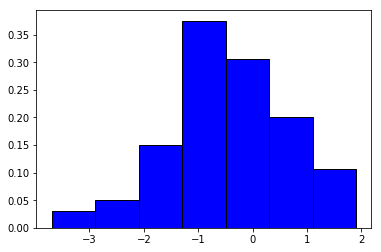

In [9]:
tmp = {round((interv[0] + interv[1]) / 2, 4): round(val[1] / h, 4) for interv, (key, val) in zip(zip(sorted(sec_counter.keys()), islice(sorted(sec_counter.keys()), 1, None)), sorted(sec_counter.items()))}
tmp = sorted(tmp.items(), key=lambda x: x[0])
tmp = np.asarray(tmp)
plt.bar(list(tmp[:, 0]),
        list(tmp[:, 1]),
        color='b',
        edgecolor='black',
        width=h)
plt.show()

In [10]:
matplotlib.rc('xtick', labelsize=50)
matplotlib.rc('ytick', labelsize=50)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


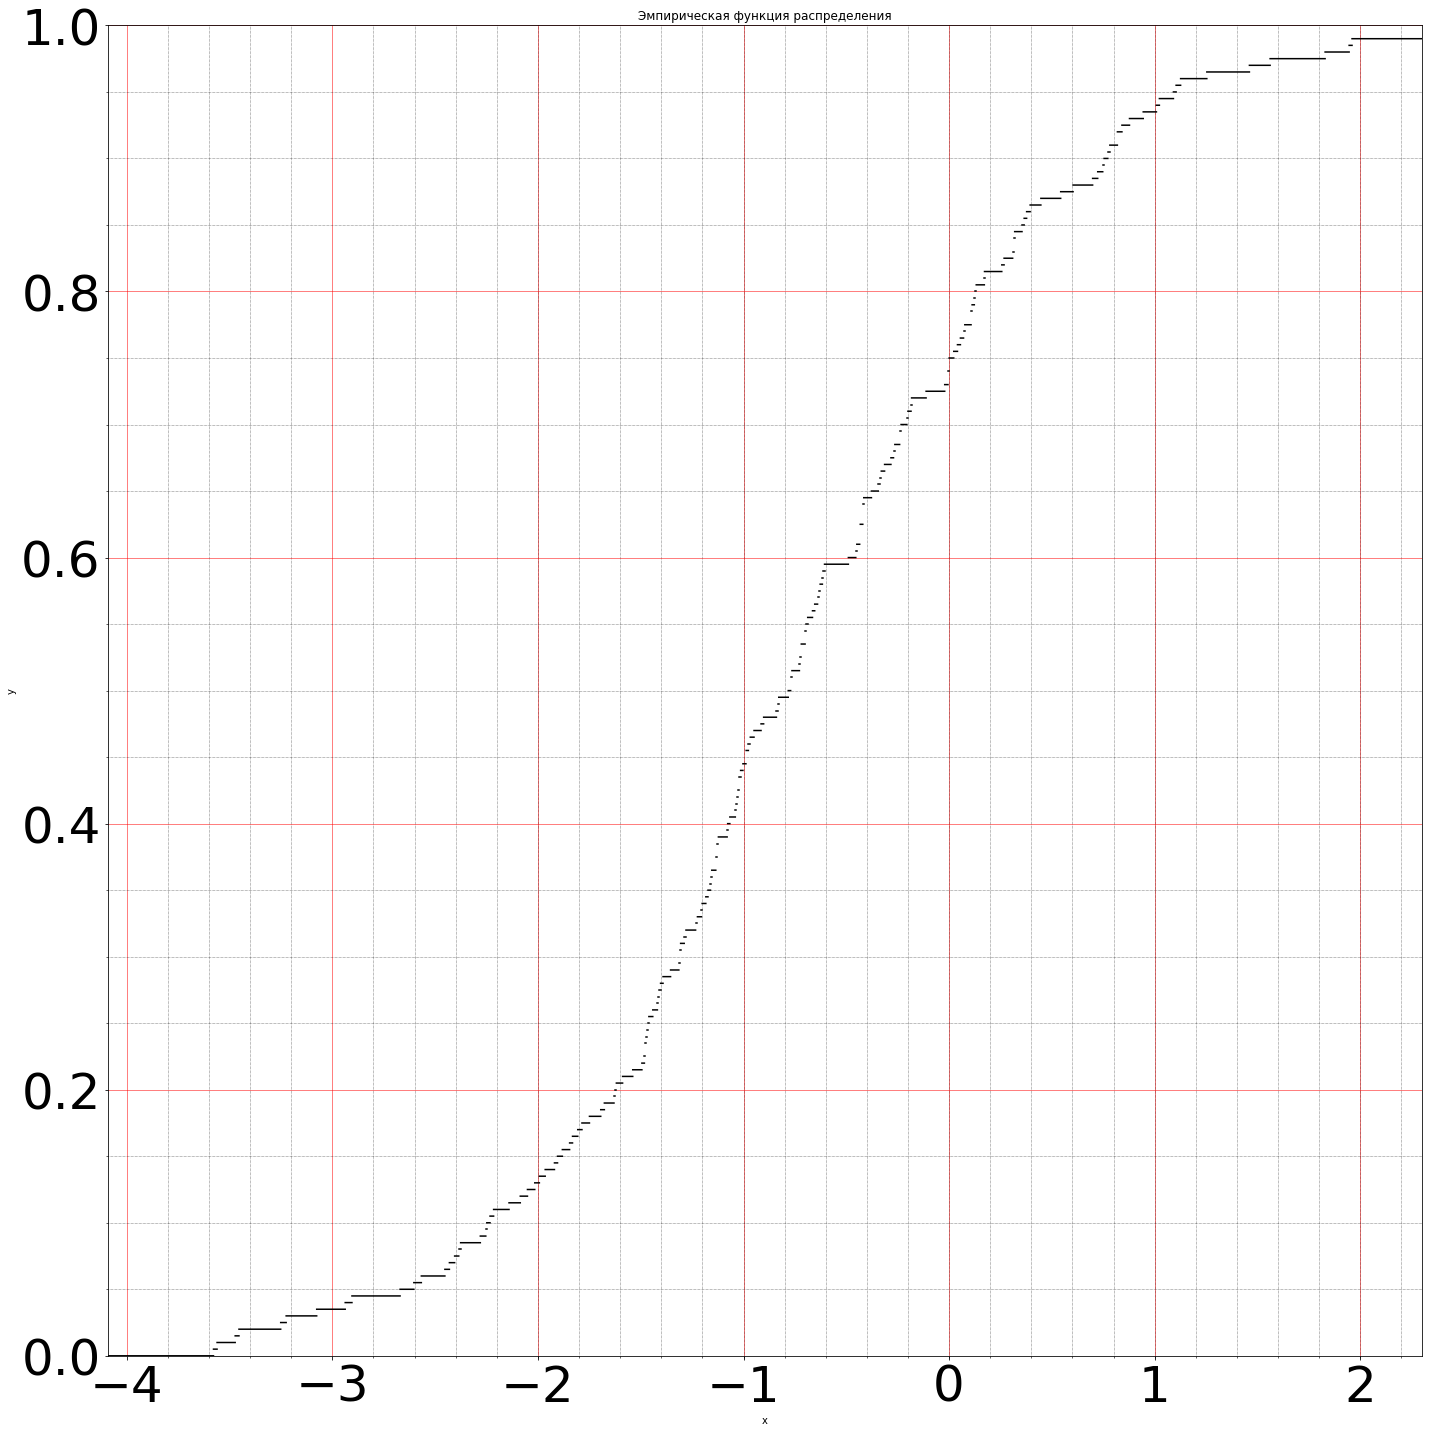

In [11]:
sr = sorted(rvs)
items = list(zip(sr, islice(sr, 1, None)))
delta = 0.00001
Xlist = [[x * delta for x in range(int(item[0] / delta), int(item[1] / delta))]
         for item in items]
Ylist = [[i / N] * len(Xlist[i]) for i in range(N-1)]

##############################################################

fig, ax = plt.subplots(figsize=(20, 20))

for X, Y in zip(Xlist, Ylist):
    ax.plot(X, Y, label='', color='black')
ax.set_title('Эмпирическая функция распределения')
ax.legend(loc='upper left')
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.set_xlim(xmin=sr[0], xmax=sr[-1])
ax.set_ylim(ymin=0, ymax=1)
fig.tight_layout()
ax.set_axisbelow(True)
ax.minorticks_on()
ax.grid(which='major', linestyle='-', linewidth='0.5', color='red')
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

plt.show()

In [12]:
Stats = namedtuple('Stats', 'mean variance std mode med skew kurtosis')

In [13]:
mean, variance, skew, kurtosis = distribution.stats(moments='mvsk')
med = distribution.median()
std = distribution.std()
mode = mode_gen[name](*params)

theoretical_stats = Stats(mean=float(mean),
                                    variance=float(variance),
                                    std=std,
                                    mode=mode,
                                    med=med,
                                    skew=float(skew),
                                    kurtosis=float(kurtosis))

In [14]:
theoretical_stats

Stats(mean=-0.9, variance=1.4115816100000003, std=1.1881000000000002, mode=-0.9, med=-0.9, skew=0.0, kurtosis=0.0)

In [15]:
mean, variance, std, mode, med, skew, kurtosis = expStats(sec_counter,
                                                          first_counter,
                                                          h)
experimental_stats = Stats(mean=mean,
                           variance=variance,
                           std=std,
                           mode=mode,
                           med=med,
                           skew=skew,
                           kurtosis=kurtosis)

In [16]:
experimental_stats

Stats(mean=-0.780189480565575, variance=1.3128730091572471, std=1.145806706716821, mode=-1.083107858579679, med=-0.8471401209479071, skew=-0.03469396042956588, kurtosis=0.2247091021994998)

In [17]:
cur_r = distribution
cur_x = sorted(list(first_counter.keys()))
cur_w = [sec_counter[key][1]
         for key in sorted(list(sec_counter.keys()))]


p = [cur_r.cdf(b) - cur_r.cdf(a) for a, b in cur_x]
s = sum(p)
wp = [abs(a - b) for a, b in zip(cur_w, p)]
m = max(wp)
new_w = deepcopy(cur_w)
new_w.append(1.0)
p.append(s)
wp.append(m)
new_x = deepcopy(cur_x)
new_x.append('-')

df = pd.DataFrame(np.round(np.array([new_w, p, wp]).T, 4),
                  index=new_x)

In [18]:
df

,0,1,2
"(-4.092737547521379, -3.2935703419831874)",0.025,0.0184,0.0066
"(-3.2935703419831874, -2.494403136444996)",0.040,0.0678,0.0278
"(-2.494403136444996, -1.6952359309068044)",0.120,0.1618,0.0418
"(-1.6952359309068044, -0.8960687253686128)",0.300,0.2497,0.0503
"(-0.8960687253686128, -0.09690151983042128)",0.245,0.2491,0.0041
"(-0.09690151983042128, 0.7022656857077703)",0.160,0.1608,0.0008
"(0.7022656857077703, 1.5014328912459618)",0.085,0.0671,0.0179
"(1.5014328912459618, 2.3006000967841533)",0.025,0.0181,0.0069
-,1.000,0.9929,0.0503


In [20]:
dec = 4
all_stats = list(zip(experimental_stats._asdict().keys(), list(zip(experimental_stats, theoretical_stats))))
result = {key: (round(e, dec), round(t, dec), round(abs(e-t), dec), round(abs(e-t)/t, dec))
          for key, (e, t) in all_stats}
df = pd.DataFrame(list(result.values()),
                  index=list(result.keys()))

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


In [21]:
df

,0,1,2,3
mean,-0.7802,-0.9000,0.1198,-0.133100
skew,-0.0347,0.0000,0.0347,inf
variance,1.3129,1.4116,0.0987,0.069900
kurtosis,0.2247,0.0000,0.2247,inf
std,1.1458,1.1881,0.0423,0.035600
mode,-1.0831,-0.9000,0.1831,-0.203500
med,-0.8471,-0.9000,0.0529,-0.058700
